In [1]:
import vector
import numpy as np
import matplotlib.pyplot as plt
import pickle
import time

In [2]:
raw_file_path = "/global/cfs/cdirs/m2616/avencast/Quantum_Entanglement/workspace_20250209_sig/results/pi_pi/ml_export/pi_pi_recon_particles.pkl"
with open(raw_file_path, "rb") as f:
    data = pickle.load(f)
test_num = -1
vis1_1 = data["tau_p_child1"][:test_num]
vis1_2 = data["tau_p_child2"][:test_num]
vis1_3 = data["tau_p_child3"][:test_num]
vis2_1 = data["tau_m_child1"][:test_num]
vis2_2 = data["tau_m_child2"][:test_num]
vis2_3 = data["tau_m_child3"][:test_num]
met = data["MET"][:test_num]
truth_nu1 = data["truth_nu_p"][:test_num]
truth_nu2 = data["truth_nu_m"][:test_num]
tau_1 = data["truth_tau_p"][:test_num]
tau_2 = data["truth_tau_m"][:test_num]
vis1 = vis1_1 + vis1_2 + vis1_3
vis2 = vis2_1 + vis2_2 + vis2_3

In [3]:
# Get \Detal R between visible particles and invisible particles
delta_R_1 = vis1.deltaR(truth_nu1)
delta_R_2 = vis2.deltaR(truth_nu2)
p_tau_1 = tau_1.p
p_tau_2 = tau_2.p

In [ ]:
print(max(p_tau_1))

In [26]:
# Get Bins
num_bins = 1000
q_delta_R_1 = np.linspace(0, 99, num_bins + 1)
bin_delta_R_1 = np.percentile(delta_R_1, q_delta_R_1)
q_delta_R_2 = np.linspace(0, 99, num_bins + 1)
bin_delta_R_2 = np.percentile(delta_R_2, q_delta_R_2)
q_p_tau_1 = np.linspace(0, 99, num_bins + 1)
bin_p_tau_1 = np.percentile(p_tau_1, q_p_tau_1)
q_p_tau_2 = np.linspace(0, 99, num_bins + 1)
bin_p_tau_2 = np.percentile(p_tau_2, q_p_tau_2)


In [ ]:
print(np.percentile(delta_R_1, 99.1))

In [27]:
# Plot
h1,x1,y1 = np.histogram2d(p_tau_1, delta_R_1, bins=(bin_p_tau_1, bin_delta_R_1))  # Normalize the histogram

In [28]:
h2,x2,y2 = np.histogram2d(p_tau_2, delta_R_2, bins=(bin_p_tau_2, bin_delta_R_2))  # Normalize the histogram

In [ ]:
plt.hist2d(p_tau_1, delta_R_1, bins=(bin_p_tau_1, bin_delta_R_1), cmap='viridis', density=True, norm='log')
plt.colorbar()
plt.xlabel("p_tau_1")
plt.ylabel("delta_R_1")
plt.show()

In [ ]:
plt.hist2d(p_tau_2, delta_R_2, bins=(bin_p_tau_2, bin_delta_R_2), cmap='viridis', density=True, norm='log')
plt.colorbar()
plt.xlabel("p_tau_2")
plt.ylabel("delta_R_2")
plt.show()

In [ ]:
plt.hist(p_tau_1, bins=100, histtype='step', label='p_tau_1')
plt.hist(p_tau_2, bins=100, histtype='step', label='p_tau_2')
plt.legend()
plt.show()

In [29]:
# Normalize the histogram
h1 = h1 / np.sum(h1)
h2 = h2 / np.sum(h2)

In [30]:
# Use RegularGridInterpolator to interpolate the histogram
from scipy.interpolate import RectBivariateSpline
interp_h1 = RectBivariateSpline(0.5 * (x1[1:] + x1[:-1]), 0.5 * (y1[1:] + y1[:-1]), h1)
interp_h2 = RectBivariateSpline(0.5 * (x2[1:] + x2[:-1]), 0.5 * (y2[1:] + y2[:-1]), h2)

In [31]:
interp_h1(p_tau_1[10], delta_R_1[10])

array([[2.13150624e-06]])

In [ ]:
# Get the probability distribution
def get_density(xi, yi, H, xedges, yedges):
    ix = np.searchsorted(xedges, xi) - 1
    iy = np.searchsorted(yedges, yi) - 1
    # 边界判断，如果不在范围内则返回 0
    if ix < 0 or ix >= H.shape[0] or iy < 0 or iy >= H.shape[1]:
        return 0.0
    # 计算该 bin 的面积
    bin_area = (xedges[ix+1] - xedges[ix]) * (yedges[iy+1] - yedges[iy])
    # 返回该 bin 的概率值
    return H[ix, iy] 

In [ ]:
get_density(p_tau_1[100], delta_R_1[100], h1, x1, y1)

In [ ]:
get_density(p_tau_2[0], delta_R_2[0], h2, x2, y2)


In [ ]:
interp_h1([p_tau_1[100], delta_R_1[100]])
interp_h2([p_tau_2[0], delta_R_2[0]])

In [14]:
# save the histogram
hist_dics = {"h1": h1, "x1": x1, "y1": y1, "h2": h2, "x2": x2, "y2": y2}
np.savez("/global/homes/b/baihong/workdir/MMC/histogram", **hist_dics)

In [ ]:
def P_deltaR(delta_R, p_tau, is_tau_1):
    if is_tau_1:
        return interp_h1([p_tau, delta_R])
    else:
        return interp_h2([p_tau, delta_R])

In [19]:
from scipy.stats import levy_stable
from scipy.optimize import fsolve

In [ ]:
M_tau = 1.777  # GeV，τ的质量（文章中给出）

def get_p_mis(m_vis, p_vis, E_vis, theta_vis, phi_vis, theta_mis, phi_mis):
    """
    根据文章 Eq. (3) 对于 hadronic 衰变（m_mis = 0），τ 质量约束为：
    
      M_tau^2 = m_vis^2 + 2 [ E_vis * p_mis - p_vis * p_mis * cos(Δθ_vm) ]
    
    其中 cos(Δθ_vm) = sinθ_vis*sinθ_mis*cos(φ_vis - φ_mis) + cosθ_vis*cosθ_mis.
    故精确定义中微子动量：
    
      p_mis = (M_tau^2 - m_vis^2) / (2*(E_vis - p_vis*cos(Δθ_vm)))
    
    此处没有额外近似，严格按照文章公式实现。
    """
    cos_dtheta = np.sin(theta_vis) * np.sin(theta_mis) * np.cos(phi_vis - phi_mis) + \
                 np.cos(theta_vis) * np.cos(theta_mis)
    numerator = M_tau**2 - m_vis**2
    denominator = 2 * (E_vis - p_vis * cos_dtheta)
    # 若分母接近零，则返回 None（表示该网格点无解）
    if np.abs(denominator) < 1e-6:
        return None
    return numerator / denominator

In [ ]:
def missing_ET_equations(thetas, phi_mis1, phi_mis2, Etx, Ety, vis_params1, vis_params2):
    """
    对于每个 τ 衰变，未知数为中微子极角 θ_mis。
    由横向 E/T 约束（文章 Eq. (3) 中的 E/T_x 和 E/T_y 方程）有：
    
       F1 = p_mis1*sin(θ_mis1)*cos(φ_mis1) + p_mis2*sin(θ_mis2)*cos(φ_mis2) - E/T_x = 0
       F2 = p_mis1*sin(θ_mis1)*sin(φ_mis1) + p_mis2*sin(θ_mis2)*sin(φ_mis2) - E/T_y = 0
    
    其中 p_mis1,2 分别由 τ 质量约束精确定义（见 get_p_mis）。
    该方程组不作任何简化，直接用于 fsolve 求解。
    """
    theta_mis1, theta_mis2 = thetas
    p_vis1, m_vis1, theta_vis1, phi_vis1 = vis_params1
    p_vis2, m_vis2, theta_vis2, phi_vis2 = vis_params2
    E_vis1 = np.sqrt(p_vis1**2 + m_vis1**2)
    E_vis2 = np.sqrt(p_vis2**2 + m_vis2**2)
    
    p_mis1 = get_p_mis(m_vis1, p_vis1, E_vis1, theta_vis1, phi_vis1, theta_mis1, phi_mis1)
    p_mis2 = get_p_mis(m_vis2, p_vis2, E_vis2, theta_vis2, phi_vis2, theta_mis2, phi_mis2)
    if p_mis1 is None or p_mis2 is None:
        return [1e6, 1e6]
    ETx_calc = p_mis1 * np.sin(theta_mis1) * np.cos(phi_mis1) + \
               p_mis2 * np.sin(theta_mis2) * np.cos(phi_mis2)
    ETy_calc = p_mis1 * np.sin(theta_mis1) * np.sin(phi_mis1) + \
               p_mis2 * np.sin(theta_mis2) * np.sin(phi_mis2)
    return [ETx_calc - Etx, ETy_calc - Ety]

In [ ]:
def compute_neutrino_four_momenta(phi_mis1, phi_mis2, Etx, Ety, vis_params1, vis_params2):
    """
    对于给定的中微子方位角 (φ_mis1, φ_mis2) 及已知的 E/T_x, E/T_y，
    利用 fsolve 精确求解中微子极角 θ_mis1, θ_mis2，使得横向 E/T 约束满足。
    解得 p_mis1, p_mis2 后，构造中微子四动量（中微子质量设为 0）。
    该步骤严格依据文章描述，无任何为简化问题的近似。
    """
    
    theta_guess = [vis_params1[2], vis_params2[2]]
    args = (phi_mis1, phi_mis2, Etx, Ety, vis_params1, vis_params2)
    sol, infodict, ier, mesg = fsolve(missing_ET_equations, theta_guess, args=args, full_output=True)
    if ier != 1:
        return None
    theta_mis1, theta_mis2 = sol
    p_vis1, m_vis1, theta_vis1, phi_vis1 = vis_params1
    p_vis2, m_vis2, theta_vis2, phi_vis2 = vis_params2
    E_vis1 = np.sqrt(p_vis1**2 + m_vis1**2)
    E_vis2 = np.sqrt(p_vis2**2 + m_vis2**2)
    p_mis1 = get_p_mis(m_vis1, p_vis1, E_vis1, theta_vis1, phi_vis1, theta_mis1, phi_mis1)
    p_mis2 = get_p_mis(m_vis2, p_vis2, E_vis2, theta_vis2, phi_vis2, theta_mis2, phi_mis2)
    if p_mis1 is None or p_mis2 is None:
        return None
    nu1 = {
        'E': p_mis1,
        'px': p_mis1 * np.sin(theta_mis1) * np.cos(phi_mis1),
        'py': p_mis1 * np.sin(theta_mis1) * np.sin(phi_mis1),
        'pz': p_mis1 * np.cos(theta_mis1)
    }
    nu2 = {
        'E': p_mis2,
        'px': p_mis2 * np.sin(theta_mis2) * np.cos(phi_mis2),
        'py': p_mis2 * np.sin(theta_mis2) * np.sin(phi_mis2),
        'pz': p_mis2 * np.cos(theta_mis2)
    }
    return nu1, nu2, (theta_mis1, theta_mis2), (p_mis1, p_mis2)

In [ ]:
def four_vector_sum(v1, v2):
    """返回两个四矢量的和（严格按照狭义相对论定义）"""
    return {
        'E': v1['E'] + v2['E'],
        'px': v1['px'] + v2['px'],
        'py': v1['py'] + v2['py'],
        'pz': v1['pz'] + v2['pz']
    }

def invariant_mass(v):
    """计算四矢量 v 的不变量质量"""
    mass2 = v['E']**2 - v['px']**2 - v['py']**2 - v['pz']**2
    return np.sqrt(max(mass2, 0))

def get_pseudorapidity(theta):
    """根据极角 θ 计算伪快度 η (η = -ln(tan(θ/2)))"""
    return -np.log(np.tan(theta / 2.0))

In [ ]:
def event_likelihood(delta_R1, p_tau1, delta_R2, p_tau2):
    """
    定义事件似然函数：
    
       L = - log [ P(ΔR₁, pτ₁) × P(ΔR₂, pτ₂) ]
    
    这里没有对似然函数做任何简化，完全按照文章 Eq. (4) 实现。
    """
    if np.isnan(delta_R1) or np.isnan(delta_R2) or np.isnan(p_tau1) or np.isnan(p_tau2):
        return np.inf
    try:
        P1 = P_deltaR(delta_R1, p_tau1, True)
        P2 = P_deltaR(delta_R2, p_tau2, False)
    except ValueError:
        return np.inf
    else:
        if P1 * P2 <= 0:
            return np.inf
        return -np.log(P1 * P2)

In [ ]:
import time

def MMC_reconstruction(Etx, Ety, vis_params1, vis_params2, phi_grid_points=50):
    start_time = time.time()
    best_weight = -np.inf
    best_solution = None
    best_MtauTau = None
    results = []
    
    phi_vals = np.linspace(0, 2*np.pi, phi_grid_points, endpoint=False)
    for phi_mis1 in phi_vals:
        for phi_mis2 in phi_vals:
            t0 = time.time()
            sol = compute_neutrino_four_momenta(phi_mis1, phi_mis2, Etx, Ety, vis_params1, vis_params2)
            t1 = time.time()
            print(f"Step 1, time: {t1 - t0}")
            if sol is None:
                continue
            nu1, nu2, (theta_mis1, theta_mis2), (p_mis1, p_mis2) = sol
            p_vis1, m_vis1, theta_vis1, phi_vis1 = vis_params1
            p_vis2, m_vis2, theta_vis2, phi_vis2 = vis_params2
            E_vis1 = np.sqrt(p_vis1**2 + m_vis1**2)
            E_vis2 = np.sqrt(p_vis2**2 + m_vis2**2)
            vis1 = {
                'E': E_vis1,
                'px': p_vis1 * np.sin(theta_vis1) * np.cos(phi_vis1),
                'py': p_vis1 * np.sin(theta_vis1) * np.sin(phi_vis1),
                'pz': p_vis1 * np.cos(theta_vis1)
            }
            vis2 = {
                'E': E_vis2,
                'px': p_vis2 * np.sin(theta_vis2) * np.cos(phi_vis2),
                'py': p_vis2 * np.sin(theta_vis2) * np.sin(phi_vis2),
                'pz': p_vis2 * np.cos(theta_vis2)
            }
            tau1 = four_vector_sum(vis1, nu1)
            tau2 = four_vector_sum(vis2, nu2)
            MtauTau = invariant_mass(four_vector_sum(tau1, tau2))
            p_tau1 = np.sqrt(tau1['px']**2 + tau1['py']**2 + tau1['pz']**2)
            p_tau2 = np.sqrt(tau2['px']**2 + tau2['py']**2 + tau2['pz']**2)
            
            eta_vis1 = get_pseudorapidity(theta_vis1)
            eta_vis2 = get_pseudorapidity(theta_vis2)
            eta_mis1 = get_pseudorapidity(theta_mis1)
            eta_mis2 = get_pseudorapidity(theta_mis2)
            dphi1 = np.abs(phi_vis1 - phi_mis1)
            if dphi1 > np.pi:
                dphi1 = 2*np.pi - dphi1
            dphi2 = np.abs(phi_vis2 - phi_mis2)
            if dphi2 > np.pi:
                dphi2 = 2*np.pi - dphi2
            delta_R1 = np.sqrt((eta_vis1 - eta_mis1)**2 + dphi1**2)
            delta_R2 = np.sqrt((eta_vis2 - eta_mis2)**2 + dphi2**2)
            
            L_event = event_likelihood(delta_R1, p_tau1, delta_R2, p_tau2)
            t2 = time.time()
            print(f"Step 2, Time: {t2 - t1}")
            weight = np.exp(-L_event)
            results.append((phi_mis1, phi_mis2, MtauTau, weight, nu1, nu2))
            if weight > best_weight:
                best_weight = weight
                best_solution = (phi_mis1, phi_mis2, nu1, nu2, theta_mis1, theta_mis2, p_mis1, p_mis2)
                best_MtauTau = MtauTau
                
    end_time = time.time()
    print(f"Total time: {end_time - start_time}")
    return best_solution, best_MtauTau, results


In [ ]:
vis_params1 = (vis1.pt[0]*np.cosh(vis1.eta[0]), vis1.m[0], vis1.theta[0], vis1.phi[0])  # τ1 可见部分参数
vis_params2 = (vis2.pt[0]*np.cosh(vis2.eta[0]), vis2.m[0], vis2.theta[0], vis2.phi[0])  # τ2 可见部分参数

# 假设事件缺失横动量分量（单位 GeV）
Etx = met[0].px
Ety = met[0].py
# 运行 MMC 算法（网格扫描点数可根据需要调整，此处设为 30）
best_solution, best_MtauTau, results = MMC_reconstruction(Etx, Ety, vis_params1, vis_params2, phi_grid_points=5)
MMC = MissingMassCalculator(Etx, Ety, vis_params1, vis_params2, phi_grid_points=5)
best_solution, best_MtauTau, results = MMC.MMC_reconstruction(Etx, Ety, vis_params1, vis_params2, interp_h1, interp_h2, phi_grid_points=5)

if best_solution is not None:
    phi_mis1, phi_mis2, nu1, nu2, theta_mis1, theta_mis2, p_mis1, p_mis2 = best_solution
    print("最佳解：")
    print("  φ_mis1 = {:.3f} rad, θ_mis1 = {:.3f} rad, p_mis1 = {:.3f} GeV".format(phi_mis1, theta_mis1, p_mis1))
    print("  φ_mis2 = {:.3f} rad, θ_mis2 = {:.3f} rad, p_mis2 = {:.3f} GeV".format(phi_mis2, theta_mis2, p_mis2))
    print("重构的 ττ 不变量质量 Mττ = {:.3f} GeV".format(best_MtauTau))
    print("中微子1 四动量：", nu1)
    print("中微子2 四动量：", nu2)
else:
    print("未能找到满足约束的解。")
    
print(f"trth nu1: E:{truth_nu1.E[0]}, px: {truth_nu1.px[0]}, py: {truth_nu1.py[0]}, pz: {truth_nu1.pz[0]}")
print(f"trth nu2: E:{truth_nu2.E[0]}, px: {truth_nu2.px[0]}, py: {truth_nu2.py[0]}, pz: {truth_nu2.pz[0]}")

In [ ]:
class MissingMassCalculator:
    def __init__(self, interpolator1, interpolator2, phi_grid_points=30):
        """
        Input:
            Etx: x component of the missing transverse energy
            Ety: y component
            vis_params1: (E, m, theta, phi) of the visible particle 1
            vis_params2: (E, m, theta, phi) of the visible particle 2
            phi_grid_points: number of grid points for the phi angle
        """
        import numpy as np
        from scipy.stats import levy_stable
        from scipy.optimize import fsolve
        
        self.phi_grid_points = phi_grid_points
        self.M_tau = 1.777
        self.interp_h1 =  interpolator1
        self.interp_h2 = interpolator2
    
    def P_deltaR(self, delta_R, p_tau, is_tau_1):
        if is_tau_1:
            return self.interp_h1([p_tau, delta_R])
        else:
            return self.interp_h2([p_tau, delta_R])
        
    def get_p_mis(self, m_vis, p_vis, E_vis, theta_vis, phi_vis, theta_mis, phi_mis):
        cos_dtheta = np.sin(theta_vis) * np.sin(theta_mis) * np.cos(phi_vis - phi_mis) + \
                    np.cos(theta_vis) * np.cos(theta_mis)
        numerator = self.M_tau**2 - m_vis**2
        denominator = 2 * (E_vis - p_vis * cos_dtheta)
        if np.abs(denominator) < 1e-6:
            return None
        return numerator / denominator

    def missing_ET_equations(self, thetas, phi_mis1, phi_mis2, Etx, Ety, vis_params1, vis_params2):
   
        theta_mis1, theta_mis2 = thetas
        p_vis1, m_vis1, theta_vis1, phi_vis1 = vis_params1
        p_vis2, m_vis2, theta_vis2, phi_vis2 = vis_params2
        E_vis1 = np.sqrt(p_vis1**2 + m_vis1**2)
        E_vis2 = np.sqrt(p_vis2**2 + m_vis2**2)
        
        p_mis1 = get_p_mis(m_vis1, p_vis1, E_vis1, theta_vis1, phi_vis1, theta_mis1, phi_mis1)
        p_mis2 = get_p_mis(m_vis2, p_vis2, E_vis2, theta_vis2, phi_vis2, theta_mis2, phi_mis2)
        if p_mis1 is None or p_mis2 is None:
            return [1e6, 1e6]
        ETx_calc = p_mis1 * np.sin(theta_mis1) * np.cos(phi_mis1) + \
                p_mis2 * np.sin(theta_mis2) * np.cos(phi_mis2)
        ETy_calc = p_mis1 * np.sin(theta_mis1) * np.sin(phi_mis1) + \
                p_mis2 * np.sin(theta_mis2) * np.sin(phi_mis2)
        return [ETx_calc - Etx, ETy_calc - Ety]

    def compute_neutrino_four_momenta(phi_mis1, phi_mis2, Etx, Ety, vis_params1, vis_params2):
    
        theta_guess = [vis_params1[2], vis_params2[2]]
        args = (phi_mis1, phi_mis2, Etx, Ety, vis_params1, vis_params2)
        sol, infodict, ier, mesg = fsolve(self.missing_ET_equations, theta_guess, args=args, full_output=True)
        if ier != 1:
            return None
        theta_mis1, theta_mis2 = sol
        p_vis1, m_vis1, theta_vis1, phi_vis1 = vis_params1
        p_vis2, m_vis2, theta_vis2, phi_vis2 = vis_params2
        E_vis1 = np.sqrt(p_vis1**2 + m_vis1**2)
        E_vis2 = np.sqrt(p_vis2**2 + m_vis2**2)
        p_mis1 = get_p_mis(m_vis1, p_vis1, E_vis1, theta_vis1, phi_vis1, theta_mis1, phi_mis1)
        p_mis2 = get_p_mis(m_vis2, p_vis2, E_vis2, theta_vis2, phi_vis2, theta_mis2, phi_mis2)
        if p_mis1 is None or p_mis2 is None:
            return None
        nu1 = {
            'E': p_mis1,
            'px': p_mis1 * np.sin(theta_mis1) * np.cos(phi_mis1),
            'py': p_mis1 * np.sin(theta_mis1) * np.sin(phi_mis1),
            'pz': p_mis1 * np.cos(theta_mis1)
        }
        nu2 = {
            'E': p_mis2,
            'px': p_mis2 * np.sin(theta_mis2) * np.cos(phi_mis2),
            'py': p_mis2 * np.sin(theta_mis2) * np.sin(phi_mis2),
            'pz': p_mis2 * np.cos(theta_mis2)
        }
        return nu1, nu2, (theta_mis1, theta_mis2), (p_mis1, p_mis2)

    def four_vector_sum(self, v1, v2):
   
        return {
            'E': v1['E'] + v2['E'],
            'px': v1['px'] + v2['px'],
            'py': v1['py'] + v2['py'],
            'pz': v1['pz'] + v2['pz']
        }

    def invariant_mass(self, v):
        mass2 = v['E']**2 - v['px']**2 - v['py']**2 - v['pz']**2
        return np.sqrt(max(mass2, 0))

    def get_pseudorapidity(self, theta):
        return -np.log(np.tan(theta / 2.0))

    def event_likelihood(self, delta_R1, p_tau1, delta_R2, p_tau2):

        if np.isnan(delta_R1) or np.isnan(delta_R2) or np.isnan(p_tau1) or np.isnan(p_tau2):
            return np.inf
        try:
            P1 = self.P_deltaR(delta_R1, p_tau1, True)
            P2 = self.P_deltaR(delta_R2, p_tau2, False)
        except ValueError:
            return np.inf
        else:
            if P1 * P2 <= 0:
                return np.inf
            return -np.log(P1 * P2)
    
    def calculation(self, Etx, Ety, vis_params1, vis_params2):
        best_weight = -np.inf
        best_solution = None
        best_MtauTau = None
        results = []
        
        phi_vals = np.linspace(0, 2*np.pi, self.phi_grid_points, endpoint=False)
        for phi_mis1 in phi_vals:
            for phi_mis2 in phi_vals:
                sol = compute_neutrino_four_momenta(phi_mis1, phi_mis2, Etx, Ety, vis_params1, vis_params2)
                if sol is None:
                    continue
                nu1, nu2, (theta_mis1, theta_mis2), (p_mis1, p_mis2) = sol
                p_vis1, m_vis1, theta_vis1, phi_vis1 = vis_params1
                p_vis2, m_vis2, theta_vis2, phi_vis2 = vis_params2
                E_vis1 = np.sqrt(p_vis1**2 + m_vis1**2)
                E_vis2 = np.sqrt(p_vis2**2 + m_vis2**2)
                vis1 = {
                    'E': E_vis1,
                    'px': p_vis1 * np.sin(theta_vis1) * np.cos(phi_vis1),
                    'py': p_vis1 * np.sin(theta_vis1) * np.sin(phi_vis1),
                    'pz': p_vis1 * np.cos(theta_vis1)
                }
                vis2 = {
                    'E': E_vis2,
                    'px': p_vis2 * np.sin(theta_vis2) * np.cos(phi_vis2),
                    'py': p_vis2 * np.sin(theta_vis2) * np.sin(phi_vis2),
                    'pz': p_vis2 * np.cos(theta_vis2)
                }
                tau1 = self.four_vector_sum(vis1, nu1)
                tau2 = self.four_vector_sum(vis2, nu2)
                MtauTau = self.invariant_mass(four_vector_sum(tau1, tau2))
                p_tau1 = np.sqrt(tau1['px']**2 + tau1['py']**2 + tau1['pz']**2)
                p_tau2 = np.sqrt(tau2['px']**2 + tau2['py']**2 + tau2['pz']**2)
                
                eta_vis1 = self.get_pseudorapidity(theta_vis1)
                eta_vis2 = self.get_pseudorapidity(theta_vis2)
                eta_mis1 = self.get_pseudorapidity(theta_mis1)
                eta_mis2 = self.get_pseudorapidity(theta_mis2)
                dphi1 = np.abs(phi_vis1 - phi_mis1)
                if dphi1 > np.pi:
                    dphi1 = 2*np.pi - dphi1
                dphi2 = np.abs(phi_vis2 - phi_mis2)
                if dphi2 > np.pi:
                    dphi2 = 2*np.pi - dphi2
                delta_R1 = np.sqrt((eta_vis1 - eta_mis1)**2 + dphi1**2)
                delta_R2 = np.sqrt((eta_vis2 - eta_mis2)**2 + dphi2**2)
                
                L_event = self.event_likelihood(delta_R1, p_tau1, delta_R2, p_tau2)

                weight = np.exp(-L_event)
                results.append((phi_mis1, phi_mis2, MtauTau, weight, nu1, nu2))
                if weight > best_weight:
                    best_weight = weight
                    best_solution = (phi_mis1, phi_mis2, nu1, nu2, theta_mis1, theta_mis2, p_mis1, p_mis2)
                    best_MtauTau = MtauTau

        return best_solution, best_MtauTau, results

In [33]:
class MissingMassCalculatorForLepHad:
    def __init__(self, hist_array: dict, phi_grid_points: int = 30):
        self.phi_grid_points = phi_grid_points
        self.M_tau = 1.777  # GeV，τ的质量
        self.interp_h1 = RegularGridInterpolator(
            (
                0.5 * (hist_array["x1"][1:] + hist_array["x1"][:-1]),
                0.5 * (hist_array["y1"][1:] + hist_array["y1"][:-1])
            ),
            hist_array["h1"]
        )
        self.interp_h2 = RegularGridInterpolator(
            (
                0.5 * (hist_array["x2"][1:] + hist_array["x2"][:-1]),
                0.5 * (hist_array["y2"][1:] + hist_array["y2"][:-1])
            ),
            hist_array["h2"]
        )
        
        a = 0

    def P_deltaR(self, delta_R, p_tau, is_tau_1):
        if is_tau_1:
            return self.interp_h1([p_tau, delta_R])
        else:
            return self.interp_h2([p_tau, delta_R])

    # -------------------------------
    # 修改后的 get_p_mis 方法：增加 m_mis 参数（默认0，即hadronic情况）
    # -------------------------------
    def get_p_mis(self, vis: vector.MomentumNumpy4D, theta_mis: float, phi_mis: float, m_mis: float = 0.0) -> vector.obj:
        # Neutrino direction as a unit vector
        neutrino_dir = vector.obj(
            px = np.sin(theta_mis) * np.cos(phi_mis),
            py = np.sin(theta_mis) * np.sin(phi_mis),
            pz = np.cos(theta_mis),
            energy = 1.0  # 初始能量标定（后续由数值求解得到p_mis）
        )
        # Compute cosine of angle between visible and missing momentum
        cos_dtheta = vis.unit().dot(neutrino_dir)
        
        if np.abs(m_mis) < 1e-6:
            # hadronic 情况，m_mis=0，解析求解
            numerator = self.M_tau**2 - vis.mass**2
            denominator = 2 * (vis.energy - vis.p * cos_dtheta)
            if np.abs(denominator) < 1e-6:
                return None
            return neutrino_dir * (numerator / denominator)
        else:
            # leptonic 情况，m_mis != 0，需要数值求解 p_mis
            # 定义方程： F(p) = vis.mass^2 + m_mis^2 + 2*(vis.energy*sqrt(p^2+m_mis^2) - vis.p*p*cos_dtheta) - M_tau^2 = 0
            def F(p):
                return vis.mass**2 + m_mis**2 + 2*(vis.energy * np.sqrt(p**2 + m_mis**2) - vis.p * p * cos_dtheta) - self.M_tau**2
            denom = 2 * (vis.energy - vis.p * cos_dtheta)
            p_initial = (self.M_tau**2 - vis.mass**2) / denom if np.abs(denom) > 1e-6 else 1.0
            sol = fsolve(F, p_initial)
            if sol[0] < 0:
                return None
            return neutrino_dir * sol[0]

    # -------------------------------
    # 原有的 missing_ET_equations 改为 missing_ET_equations_extended，增加 m_mis 参数
    # -------------------------------
    def missing_ET_equations_extended(
            self,
            thetas: np.ndarray,
            phi_mis1: float,
            phi_mis2: float,
            Etx: float, Ety: float,
            vis_1: vector.MomentumNumpy4D,
            vis_2: vector.MomentumNumpy4D,
            m_mis1: float,
            m_mis2: float
    ):
        theta_mis1, theta_mis2 = thetas

        p_mis1 = self.get_p_mis(vis_1, theta_mis1, phi_mis1, m_mis1)
        p_mis2 = self.get_p_mis(vis_2, theta_mis2, phi_mis2, m_mis2)

        if p_mis1 is None or p_mis2 is None:
            return [1e6, 1e6]
        ETx_calc = p_mis1.x + p_mis2.x
        ETy_calc = p_mis1.y + p_mis2.y

        return [ETx_calc - Etx, ETy_calc - Ety]

    # -------------------------------
    # 新增 compute_neutrino_four_momenta_leptonic 方法，处理leptonic时扫描的情况
    # -------------------------------
    def compute_neutrino_four_momenta_leptonic(
            self, phi_mis1: float, phi_mis2: float, Etx: float, Ety: float,
            vis_1: vector.MomentumNumpy4D,
            vis_2: vector.MomentumNumpy4D,
            m_mis1: float, m_mis2: float
    ):
        theta_guess = np.array([vis_1.theta, vis_2.theta])
        args = (phi_mis1, phi_mis2, Etx, Ety, vis_1, vis_2, m_mis1, m_mis2)
        sol, infodict, ier, mesg = fsolve(self.missing_ET_equations_extended, theta_guess, args=args, full_output=True)
        if ier != 1:
            return None
        theta_mis1, theta_mis2 = sol

        p_mis1 = self.get_p_mis(vis_1, theta_mis1, phi_mis1, m_mis1)
        p_mis2 = self.get_p_mis(vis_2, theta_mis2, phi_mis2, m_mis2)

        if p_mis1 is None or p_mis2 is None:
            return None

        # Construct neutrino four-momenta as vector objects.
        # 注意：对于 leptonic 衰变，能量 = sqrt(p^2 + m_mis^2)
        nu1 = vector.obj(
            px = p_mis1.x,
            py = p_mis1.y,
            pz = p_mis1.z,
            energy = p_mis1.mag if np.abs(m_mis1) < 1e-6 else np.sqrt(p_mis1.mag**2 + m_mis1**2)
        )
        nu2 = vector.obj(
            px = p_mis2.x,
            py = p_mis2.y,
            pz = p_mis2.z,
            energy = p_mis2.mag if np.abs(m_mis2) < 1e-6 else np.sqrt(p_mis2.mag**2 + m_mis2**2)
        )
        return nu1, nu2

    # -------------------------------
    # 原有的 event_likelihood 方法保持不变
    # -------------------------------
    def event_likelihood(self, delta_R1: float, p_tau1: float, delta_R2: float, p_tau2: float):
        if np.isnan(delta_R1) or np.isnan(delta_R2) or np.isnan(p_tau1) or np.isnan(p_tau2):
            return np.inf
        try:
            P1 = self.P_deltaR(delta_R1, p_tau1, True)
            P2 = self.P_deltaR(delta_R2, p_tau2, False)
        except ValueError:
            return np.inf
        else:
            if P1 * P2 <= 0:
                return np.inf
            return -np.log(P1 * P2)

    # -------------------------------
    # 新增 calculation_leptonic 方法，扫描 φ_mis 与 m_mis 网格
    # -------------------------------
    def calculation(
            self,
            Etx: float, Ety: float,
            vis_1: vector.MomentumNumpy4D,
            vis_2: vector.MomentumNumpy4D,
            decay_mode1: str,  # "leptonic" 或 "hadronic"
            decay_mode2: str
    ):
        # 对于leptonic衰变，扫描 m_mis 在[0, 1] GeV内，若hadronic则固定为0
        m_mis_grid1 = np.linspace(0.0, 1, 20) if decay_mode1=="leptonic" else [0.0]
        m_mis_grid2 = np.linspace(0.0, 1, 20) if decay_mode2=="leptonic" else [0.0]

        best_weight = -np.inf
        best_solution = None
        results = []

        phi_vals = np.linspace(0, 2 * np.pi, self.phi_grid_points, endpoint=False)
        for phi_mis1 in phi_vals:
            for phi_mis2 in phi_vals:
                for m_mis1 in m_mis_grid1:
                    for m_mis2 in m_mis_grid2:
                        sol = self.compute_neutrino_four_momenta_leptonic(phi_mis1, phi_mis2, Etx, Ety, vis_1, vis_2, m_mis1, m_mis2)
                        if sol is None:
                            continue
                        nu1, nu2 = sol
                        tau1 = vis_1 + nu1
                        tau2 = vis_2 + nu2
                        MtauTau = (tau1 + tau2).mass
                        p_tau1 = tau1.p
                        p_tau2 = tau2.p
                        delta_R1 = vis_1.deltaR(nu1)
                        delta_R2 = vis_2.deltaR(nu2)
                        L_event = self.event_likelihood(delta_R1, p_tau1, delta_R2, p_tau2)
                        weight = np.exp(-np.clip(L_event, 0, 500))
                        results.append((phi_mis1, phi_mis2, m_mis1, m_mis2, MtauTau, weight, nu1, nu2))
                        if weight > best_weight:
                            best_weight = weight
                            best_solution = (phi_mis1, phi_mis2, m_mis1, m_mis2, nu1, nu2)
        return best_solution, results


In [77]:
class MMC:
    def __init__(self, hist_array: dict, phi_grid_points: int = 30):

        self.phi_grid_points = phi_grid_points
        self.M_tau = 1.777  # GeV
        self.interp_h1 = RegularGridInterpolator(
            (
                0.5 * (hist_array["x1"][1:] + hist_array["x1"][:-1]),
                0.5 * (hist_array["y1"][1:] + hist_array["y1"][:-1])
            ),
            hist_array["h1"]
        )
        self.interp_h2 = RegularGridInterpolator(
            (
                0.5 * (hist_array["x2"][1:] + hist_array["x2"][:-1]),
                0.5 * (hist_array["y2"][1:] + hist_array["y2"][:-1])
            ),
            hist_array["h2"]
        )

        a=0

    def P_deltaR(self, delta_R, p_tau, is_tau_1):
        if is_tau_1:
            return self.interp_h1([p_tau, delta_R])
        else:
            return self.interp_h2([p_tau, delta_R])

    def get_p_mis(self, vis: vector.MomentumNumpy4D, theta_mis: float, phi_mis: float, m_mis: float = 0.0) -> vector.obj:
        # Neutrino direction as a unit vector
        neutrino_dir = vector.obj(
            px = np.sin(theta_mis) * np.cos(phi_mis),
            py = np.sin(theta_mis) * np.sin(phi_mis),
            pz = np.cos(theta_mis),
            energy = 1.0  
        )
        # Compute cosine of angle between visible and missing momentum
        cos_dtheta = vis.unit().dot(neutrino_dir)
        
        if np.abs(m_mis) < 1e-6:
            numerator = self.M_tau**2 - vis.mass**2
            denominator = 2 * (vis.energy - vis.p * cos_dtheta)
            if np.abs(denominator) < 1e-6:
                return None
            return neutrino_dir * (numerator / denominator)
        else:
            #  F(p) = vis.mass^2 + m_mis^2 + 2*(vis.energy*sqrt(p^2+m_mis^2) - vis.p*p*cos_dtheta) - M_tau^2 = 0
            def F(p):
                return vis.mass**2 + m_mis**2 + 2*(vis.energy * np.sqrt(p**2 + m_mis**2) - vis.p * p * cos_dtheta) - self.M_tau**2
            denom = 2 * (vis.energy - vis.p * cos_dtheta)
            p_initial = (self.M_tau**2 - vis.mass**2) / denom if np.abs(denom) > 1e-6 else 1.0
            sol = fsolve(F, p_initial)
            if sol[0] < 0:
                return None
            return neutrino_dir * sol[0]

    def missing_ET_equations(
            self,
            thetas: np.ndarray,
            phi_mis1: float,
            phi_mis2: float,
            Etx: float, Ety: float,
            vis_1: vector.MomentumNumpy4D,
            vis_2: vector.MomentumNumpy4D,
            m_mis1: float,
            m_mis2: float
    ):
        theta_mis1, theta_mis2 = thetas

        p_mis1 = self.get_p_mis(vis_1, theta_mis1, phi_mis1, m_mis1)
        p_mis2 = self.get_p_mis(vis_2, theta_mis2, phi_mis2, m_mis2)

        if p_mis1 is None or p_mis2 is None:
            return [1e6, 1e6]
        ETx_calc = p_mis1.x + p_mis2.x
        ETy_calc = p_mis1.y + p_mis2.y

        return [ETx_calc - Etx, ETy_calc - Ety]

    def compute_neutrino_four_momenta(
            self, phi_mis1: float, phi_mis2: float, Etx: float, Ety: float,
            vis_1: vector.MomentumNumpy4D,
            vis_2: vector.MomentumNumpy4D,
            m_mis1: float, m_mis2: float
    ):
        theta_guess = np.array([vis_1.theta, vis_2.theta])
        args = (phi_mis1, phi_mis2, Etx, Ety, vis_1, vis_2, m_mis1, m_mis2)
        sol, infodict, ier, mesg = fsolve(self.missing_ET_equations, theta_guess, args=args, full_output=True)
        if ier != 1:
            return None
        theta_mis1, theta_mis2 = sol

        # Compute missing momenta as vectors
        p_mis1 = self.get_p_mis(vis_1, theta_mis1, phi_mis1)
        p_mis2 = self.get_p_mis(vis_2, theta_mis2, phi_mis2)

        if p_mis1 is None or p_mis2 is None:
            return None  # Invalid solution, return None

        nu1 = vector.obj(
            px = p_mis1.x,
            py = p_mis1.y,
            pz = p_mis1.z,
            energy = p_mis1.mag if np.abs(m_mis1) < 1e-6 else np.sqrt(p_mis1.mag**2 + m_mis1**2)
        )
        nu2 = vector.obj(
            px = p_mis2.x,
            py = p_mis2.y,
            pz = p_mis2.z,
            energy = p_mis2.mag if np.abs(m_mis2) < 1e-6 else np.sqrt(p_mis2.mag**2 + m_mis2**2)
        )
        
        return nu1, nu2

    def event_likelihood(self, delta_R1: float, p_tau1: float, delta_R2: float, p_tau2: float):

        if np.isnan(delta_R1) or np.isnan(delta_R2) or np.isnan(p_tau1) or np.isnan(p_tau2):
            return np.inf
        try:
            P1 = self.P_deltaR(delta_R1, p_tau1, True)
            P2 = self.P_deltaR(delta_R2, p_tau2, False)
        except ValueError:
            return np.inf
        else:
            if P1 * P2 <= 0:
                return np.inf
            return -np.log(P1 * P2)

    def calculation(
            self,
            Etx: float, Ety: float,
            vis_1: vector.MomentumNumpy4D,
            vis_2: vector.MomentumNumpy4D,
            decay_mode1: str,  # "leptonic" 或 "hadronic"
            decay_mode2: str
    ):
        # For leptonic decay, scan m_mis in [0, 0.5] GeV, if hadronic, fix it to 0
        m_mis_grid1 = np.linspace(0.01, 0.6, 10) if decay_mode1=="leptonic" else [0.0]
        m_mis_grid2 = np.linspace(0.01, 0.6, 10) if decay_mode2=="leptonic" else [0.0]

        best_weight = -np.inf
        best_solution = None
        results = []

        phi_vals = np.linspace(0, 2 * np.pi, self.phi_grid_points, endpoint=False)
        for phi_mis1 in phi_vals:
            for phi_mis2 in phi_vals:
                for m_mis1 in m_mis_grid1:
                    for m_mis2 in m_mis_grid2:
                        sol = self.compute_neutrino_four_momenta(phi_mis1, phi_mis2, Etx, Ety, vis_1, vis_2, m_mis1, m_mis2)
                        if sol is None:
                            continue
                        nu1, nu2 = sol
                        tau1 = vis_1 + nu1
                        tau2 = vis_2 + nu2
                        MtauTau = (tau1 + tau2).mass
                        p_tau1 = tau1.p
                        p_tau2 = tau2.p
                        delta_R1 = vis_1.deltaR(nu1)
                        delta_R2 = vis_2.deltaR(nu2)
                        L_event = self.event_likelihood(delta_R1, p_tau1, delta_R2, p_tau2)
                        weight = np.exp(-np.clip(L_event, 0, 500))
                        results.append((phi_mis1, phi_mis2, m_mis1, m_mis2, MtauTau, weight, nu1, nu2))
                        if weight > best_weight:
                            best_weight = weight
                            best_solution = (phi_mis1, phi_mis2, m_mis1, m_mis2, nu1, nu2)
        return best_solution, results

In [48]:
mmc = MMC(hist_dics, phi_grid_points=15)

# 假设事件缺失横动量分量（单位 GeV）
Etx = met[2].px
Ety = met[2].py
best_solution, results = mmc.calculation(Etx = met[2].px, Ety = met[2].py, vis_1 = vis1[2], vis_2 = vis2[2], decay_mode1 = "hadronic", decay_mode2 = "hadronic")
if best_solution is not None:
    phi_mis1, phi_mis2, m_mis1, m_mis2, nu1, nu2 = best_solution
    print("最佳解：")
    # print("  φ_mis1 = {:.3f} rad, θ_mis1 = {:.3f} rad, p_mis1 = {:.3f} GeV".format(phi_mis1, theta_mis1, p_mis1))
    # print("  φ_mis2 = {:.3f} rad, θ_mis2 = {:.3f} rad, p_mis2 = {:.3f} GeV".format(phi_mis2, theta_mis2, p_mis2))
    # print("重构的 ττ 不变量质量 Mττ = {:.3f} GeV".format(best_MtauTau))
    print("中微子1 四动量：", nu1)
    print("中微子2 四动量：", nu2)
    print("Truth nu1: ", truth_nu1[2])
    print("Truth nu2: ", truth_nu2[2])
else:
    print("未能找到满足约束的解。")

最佳解：
中微子1 四动量： MomentumObject4D(px=-5.383156967069575, py=1.1442253358503358, pz=6.53125003030537, E=8.540776165529419)
中微子2 四动量： MomentumObject4D(px=-1.1975619786756467e-06, py=-3.6857167865170592e-06, pz=-0.00025300297673341393, E=0.00025303265579543595)
Truth nu1:  MomentumObject4D(px=16.4263973236084, py=-1.6895631551742554, pz=-13.907143592834473, mass=0.0)
Truth nu2:  MomentumObject4D(px=-46.095149993896484, py=6.413871765136719, pz=-39.1239128112793, mass=0.015625)


In [49]:
# Then for leptonic decay
raw_file_path = "/global/cfs/cdirs/m2616/avencast/Quantum_Entanglement/workspace_20250209_sig/results/e_pi/ml_export/lep_pi_recon_particles.pkl"
with open(raw_file_path, "rb") as f:
    data = pickle.load(f)
test_num = -1
e_vis1_1 = data["tau_p_child1"][:test_num]
e_vis1_2 = data["tau_p_child2"][:test_num]
e_vis1_3 = data["tau_p_child3"][:test_num]
e_vis2_1 = data["tau_m_child1"][:test_num]
e_vis2_2 = data["tau_m_child2"][:test_num]
e_vis2_3 = data["tau_m_child3"][:test_num]
e_met = data["MET"][:test_num]
e_truth_nu1 = data["truth_nu_p"][:test_num]
e_truth_nu2 = data["truth_nu_m"][:test_num]
e_tau_1 = data["truth_tau_p"][:test_num]
e_tau_2 = data["truth_tau_m"][:test_num]
e_vis1 = e_vis1_1 + e_vis1_2 + e_vis1_3
e_vis2 = e_vis2_1 + e_vis2_2 + e_vis2_3

In [63]:
e_delta_R_1 = e_vis1.deltaR(e_truth_nu1)
e_delta_R_2 = e_vis2.deltaR(e_truth_nu2)
e_p_tau1 = e_tau_1.p
e_p_tau2 = e_tau_2.p

In [73]:
num_bins = 1000
q_delta_R_1 = np.linspace(0, 99, num_bins + 1)
bin_e_delta_R_1 = np.percentile(e_delta_R_1, q_delta_R_1)
q_p_tau1 = np.linspace(0, 99, num_bins + 1)
bin_e_p_tau1 = np.percentile(e_p_tau1, q_p_tau1)
q_delta_R_2 = np.linspace(0, 99, num_bins + 1)
bin_e_delta_R_2 = np.percentile(e_delta_R_2, q_delta_R_2)
q_p_tau2 = np.linspace(0, 99, num_bins + 1)
bin_e_p_tau2 = np.percentile(e_p_tau2, q_p_tau2)

In [65]:
e_h1, e_x1, e_y1 = np.histogram2d(e_p_tau1, e_delta_R_1, bins=[bin_e_p_tau1, bin_e_delta_R_1])
e_h2, e_x2, e_y2 = np.histogram2d(e_p_tau2, e_delta_R_2, bins=[bin_e_p_tau2, bin_e_delta_R_2])

In [66]:
e_hist_dics = {
    "x1": e_x1,
    "y1": e_y1,
    "h1": e_h1.T,
    "x2": e_x2,
    "y2": e_y2,
    "h2": e_h2.T
}

np.savez("/global/homes/b/baihong/workdir/MMC/e_pi_histogram", **e_hist_dics)

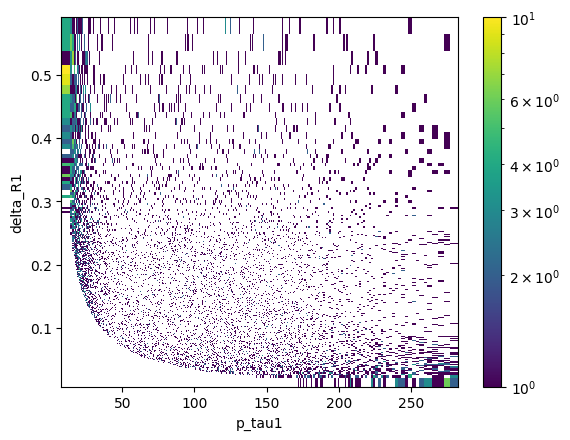

In [67]:
plt.hist2d(e_p_tau1, e_delta_R_1, bins=[bin_e_p_tau1, bin_e_delta_R_1], cmap="viridis", norm = "log")
plt.xlabel("p_tau1")
plt.ylabel("delta_R1")
plt.colorbar()
plt.show()

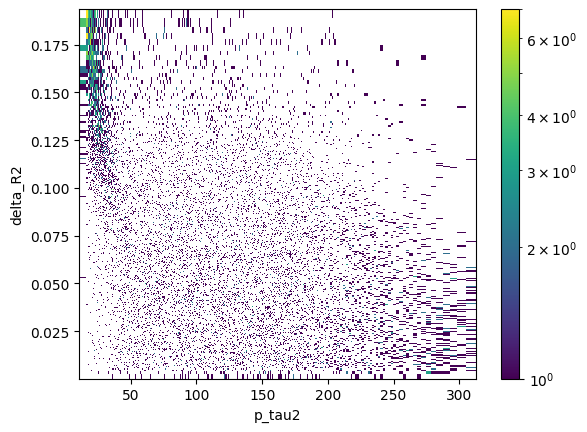

In [76]:
plt.hist2d(e_p_tau2, e_delta_R_2, bins=[bin_e_p_tau2, bin_e_delta_R_2], cmap="viridis", norm = "log")
plt.xlabel("p_tau2")
plt.ylabel("delta_R2")
plt.colorbar()
plt.show()

In [80]:
# 假设事件缺失横动量分量（单位 GeV）
mmc = MMC(e_hist_dics, phi_grid_points=15)

best_solution, results = mmc.calculation(Etx = e_met[2].px, Ety = e_met[2].py, vis_1 = e_vis1[2], vis_2 = e_vis2[2], decay_mode1 = "hadronic", decay_mode2 = "leptonic")
if best_solution is not None:
    phi_mis1, phi_mis2, m_mis1, m_mis2, nu1, nu2 = best_solution
    print("最佳解：")
    # print("  φ_mis1 = {:.3f} rad, θ_mis1 = {:.3f} rad, p_mis1 = {:.3f} GeV".format(phi_mis1, theta_mis1, p_mis1))
    # print("  φ_mis2 = {:.3f} rad, θ_mis2 = {:.3f} rad, p_mis2 = {:.3f} GeV".format(phi_mis2, theta_mis2, p_mis2))
    # print("重构的 ττ 不变量质量 Mττ = {:.3f} GeV".format(best_MtauTau))
    print("中微子1 四动量：", nu1)
    print("中微子2 四动量：", nu2)
    print(m_mis2)
    print("Truth nu1: ", e_truth_nu1[2])
    print("Truth nu2: ", e_truth_nu2[2])
else:
    print("未能找到满足约束的解。")

最佳解：
中微子1 四动量： MomentumObject4D(px=0.3024434262054547, py=0.13465648902966387, pz=0.8367589487537518, E=0.8998721767074334)
中微子2 四动量： MomentumObject4D(px=4.024562184280444e-06, py=1.7918505302496325e-06, pz=3.293892258319687e-05, E=0.20666666933855482)
0.20666666666666667
Truth nu1:  MomentumObject4D(px=-3.8972249031066895, py=-1.3866956233978271, pz=-9.13939094543457, mass=0.0)
Truth nu2:  MomentumObject4D(px=22.880306243896484, py=13.687732696533203, pz=-35.59480667114258, mass=0.4422178566455841)
